# AlloBench Dataset Creation Pipeline

In [1]:
import os, sys

# Add the src directory to PYTHONPATH
module_path = os.path.abspath('src')
if module_path not in sys.path:
    sys.path.append(module_path)

# Import local modules from src directory
import parse_asd_xml

## Get AlloSteric Database (ASD) Data

ASD provides the allosteric site information in a tab delimited file (ASD_Release_202309_AS.txt) or as XML files (ASD_Release_202306_XF.tar.gz). However, 1620 entries of 3102 in ASD_Release_202309_AS.txt are missing the allosteric site residues. Hence, the data is parsed from the XML files instead.

Download the ASD_Release_202306_XF.tar.gz from https://mdl.shsmu.edu.cn/ASD/module/download/download.jsp?tabIndex=1 and place it in the directory of this notebook.

In [2]:
# Input directory (XML files are already extracted)
asd_xml_directory = '../xml_file'  # Path to the directory containing XML files

# Output filenames
output_filename = 'AlloBench.csv'           # Final output file


### 1. Parse the data in ASD XML Files

In [3]:
df_asd = parse_asd_xml.asd_to_df(asd_xml_directory)
df_asd

Found 2419 XML files in ../xml_file


,Protein ASD ID,Gene,Organism,UniProt ID,PDB ID,Protein Class,EC Number,Modulator ASD ID,Modulator Alias,Modulator Chain,Modulator Class,Allosteric Activity,Modulator Name,Modulator Residue ID,ASD Function,Position,PubMed,Reference Title,Site Overlap,ASD Allosteric Site Residues
0,ASD17290000_1,HASPIN,Human,Q8TF76,5HTC,Transferase,[2.7.11.1],ASD17290001,66M,C,Lig,Inhibitor,"(2R)-2-{[6-({[(2S,3S,4R,5R)-5-(6-amino-9H-puri...",101,Allosteric Function,Allosteric Position,27139824,Co-crystal structures of the protein kinase ha...,Yes,"[C-ARG-2, C-LYS-3, C-LYS-4]"
1,ASD17290000_1,HASPIN,Human,Q8TF76,5HTB,Transferase,[2.7.11.1],ASD17290002,6L5,C,Lig,Inhibitor,"(3R)-4-amino-3-{[6-({[(2S,3S,4R,5R)-5-(6-amino...",101,Allosteric Function,Allosteric Position,27139824,Co-crystal structures of the protein kinase ha...,Yes,"[C-GLN-5, C-ARG-2, C-LYS-3, C-LYS-4]"
2,ASD12030000_1,purN,Escherichia coli (strain K12),P08179,4GAR,Transferase,[2.1.2.2],ASD10228001,NMY,A,Lig,Inhibitor,"(2R,3S,4R,5R,6R)-5-amino-2-(aminomethyl)-6-[(1...",3161,Protein-DNA/RNA Interaction Regulator,Inner DNA/RNA,22902368,Allosteric control of the ribosome by small-mo...,No,[A-SEC-1923]
3,ASD06640000_2,sbcB,Escherichia coli,P04995,3HL8,Hydrolase,[3.1.11.1],ASD06640001,BBP,A,Lig,Inhibitor,"5-tert-butyl-2-(6-chloro-1,3-benzothiazol-2-yl...",501,Protein-Protein Interaction Regulator,Inner Protein,20018747,Small-molecule tools for dissecting the roles ...,Yes,"[A-PRO-228, A-TRP-245, A-LEU-264, A-ALA-312, A..."
4,ASD05860000_3,tetR,E.coli,P0ACT4,6RBM,Transcription Factor,[],None,MIY,A,Lig,Inhibitor,"(4S,4AS,5AR,12AS)-4,7-BIS(DIMETHYLAMINO)-3,10,...",301,Allosteric function,Allosteric position,,,No,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3167,ASD21370000_1,pvdP,Pseudomonas aeruginosa (strain ATCC 15692 / DS...,Q9I188,6RRP,Other Proteins,[],None,URS,A,Lig,Inhibitor,N-PHENYLTHIOUREA,601,Allosteric function,Allosteric position,,,No,[]
3168,ASD01320000_1,PYGM,Human,P11217,1Z8D,Transferase,[2.4.1.1],ASD00030001,AMP,A,Lig,Activator,"[(2R,3S,4R,5R)-5-(6-aminopurin-9-yl)-3,4-bis(o...",900,Inner Protein Regulator,Inner Protein,16523484,The crystal structure of human muscle glycogen...,No,"[A-TRP-67, A-GLN-71, A-TYR-75, A-ARG-309, A-AR..."
3169,ASD01320000_1,PYGM,Human,P11217,1Z8D,Transferase,[2.4.1.1],ASD01320045,ADE,A,Lig,Inhibitor,9H-purin-6-amine,902,Inner Protein Regulator,Inner Protein,16523484,The crystal structure of human muscle glycogen...,No,"[A-ASN-282, A-PHE-285, A-ALA-610, A-GLY-612, A..."
3170,ASD11340000_1,ipgm-1,Caenorhabditis elegans,G5EFZ1,5KGN,Isomerase,[],None,macrocyclic peptide,C,Pep,Inhibitor,macrocyclic peptide,None,Allosteric function,Allosteric position,28368002,Macrocycle peptides delineate locked-open inhi...,No,[]


In [4]:
# Make the UniProt and PDB IDs uppercase to facilitate merging on these later
df_asd['PDB ID'] = df_asd['PDB ID'].str.upper()
df_asd['UniProt ID'] = df_asd['UniProt ID'].str.upper()

print('Number of Rows:             ', df_asd.shape[0])
print('Number of Unique PDB IDs:   ', df_asd['PDB ID'].nunique())
print('Number of Unique UniProt AC:', df_asd['UniProt ID'].nunique())

Number of Rows:              3172
Number of Unique PDB IDs:    2993
Number of Unique UniProt AC: 701


### 2. Fix Obsolete PDB Entries

The structures of the biomolecules will be downloaded from the PDB; thus, having the correct PDB IDs is essential. Some PDB IDs in ASD are obsolete. The list of obsolete PDB IDs is downloaded from the Protein Data Bank. The obsolete PDB IDs are replaced by the superseded PDB IDs, and structures without any superseded PDB IDs are removed.

In [5]:
import requests
import json
import gzip
import pandas as pd

response = requests.get('https://files.wwpdb.org/pub/pdb/holdings/all_removed_entries.json.gz')

obsolete_pdb = {}
for pdb_id, value in json.loads(gzip.decompress(response.content)).items():
    if 'superseded_by' in value:
        # Select the last element in the list of superseded PDB IDs
        obsolete_pdb[pdb_id] = value['superseded_by'] # [-1] 
    else:
        obsolete_pdb[pdb_id] = []


df_obsolete_pdb = pd.DataFrame.from_dict(obsolete_pdb, orient='index')
df_obsolete_pdb.index.name = 'Obsolete PDB ID'

# Obsolete PDB IDs in ASD
df_obsolete_pdb_asd = df_obsolete_pdb[df_obsolete_pdb.index.isin(df_asd['PDB ID'])]

# Replace the obsolete PDB IDs
df_asd['PDB ID'] = df_asd['PDB ID'].replace(df_obsolete_pdb_asd.to_dict()[0])

# Check if any of the obsolete PDB IDs had more than one updated PDB IDs
df_obsolete_pdb_asd

,0,1,2
Obsolete PDB ID,,,
1HWZ,6DHD,None,None
3MVQ,6DHL,None,None
3MW9,6DHM,None,None
3QMU,6DHQ,None,None
4GAR,4V9C,None,None
4GAU,4V9C,None,None
4LEG,5J94,None,None
5HOT,8V9C,None,None


While most obsolete PDB IDs are superseded by only one PDB ID, there exists obsolete PDB IDs superseded by multiple PDB IDs. However, the ASD does not contain such structures.

In [6]:
print('Number of Rows:             ', df_asd.shape[0])
print('Number of Unique PDB IDs:   ', df_asd['PDB ID'].nunique())
print('Number of Unique UniProt AC:', df_asd['UniProt ID'].nunique())

Number of Rows:              3172
Number of Unique PDB IDs:    2991
Number of Unique UniProt AC: 701


### 3. Fix Obsolete UniProt Entries

The active site information will be obtained from the UniProt database hence it is critical to have the correct UniProt ID for the ASD protein structures. The code to fix the obsolete UniProt IDs is in the fix_uniprot_id.py

1. Get the list of UniProt IDs in the structure corresponding to each PDB ID in the ASD from the PDB using GraphQL  
2. If the UniProt ID from ASD is present in the UniProt IDs fetched from the PDB then the UniProt ID from ASD is correct and does not need any modification.  
3. If the UniProt ID from ASD is absent in the UniProt IDs fetched from the PDB then,  
    a. If only 1 UniProt ID was obtained then that ID may be assgined without ambiguity  
    b. If 0 or multiple UniProt IDs were obtained then these must be manually reviewed and any suitable UniProt IDs may be included in the subsequent cells.

In [7]:
def uniprot_from_pdb(pdb_ids):
    """ Get the UniProt IDs for the chains in the structures with the PDB IDs """
    pdb_ids_string = '", "'.join(pdb_ids)

    body = 'query {entries(entry_ids: ["' + pdb_ids_string + '"])' + """
      {
        rcsb_id
        polymer_entities {
          uniprots {
            rcsb_id
          }
        }
      }
    }
    """
    response = requests.post(url='https://data.rcsb.org/graphql', json={"query": body})
    response_data = response.json()

    id_mapping = []
    for record in response_data['data']['entries']:
        rcsb_id = record['rcsb_id']
        uniprot_ids = set()
        for entity in record['polymer_entities']:
            if entity['uniprots']:
                uniprot_ids.add(entity['uniprots'][0]['rcsb_id'])
        id_mapping.append([rcsb_id, uniprot_ids])
        
    return pd.DataFrame(id_mapping, columns=['PDB ID', 'PDB UniProt ID'])

In [8]:
# Create a pandas DataFrame with only PDB ID and UniProt ID
df_asd_subset = df_asd[['PDB ID', 'UniProt ID']].drop_duplicates().copy()

# Get the UniProt IDs of the chains in the proteins from PDB website
df_pdb = uniprot_from_pdb(df_asd_subset['PDB ID'])

df_pdb

,PDB ID,PDB UniProt ID
0,5HTC,{Q8TF76}
1,5HTB,{Q8TF76}
2,4V9C,"{P0A7X3, P60624, P0AG59, P0C018, P0A7L3, P0AG6..."
3,3HL8,{P04995}
4,6RBM,{P0ACT4}
...,...,...
2992,7O83,{}
2993,7R7I,{Q06124}
2994,7RCT,{Q06124}
2995,7XW5,"{P62873, P59768, P63092, P01222, P01215, P16473}"


In [9]:
# Count the number of UniProt IDs obtained from PDB website for each PDB ID
df_pdb['_num_pdb_uniprot'] = df_pdb['PDB UniProt ID'].apply(len)
df_merged = df_asd_subset.merge(df_pdb.dropna(subset='PDB UniProt ID'), how='left', on='PDB ID')

# Check if the UniProt ID in ASD is present in the UniProt IDs obtained from PDB website
df_merged['_present'] = df_merged.apply(lambda x: x['UniProt ID'] in x['PDB UniProt ID'], axis=1)

df_present = df_merged.loc[df_merged['_present'], ['PDB ID', 'UniProt ID']]
df_present['PDB UniProt ID'] = df_present['UniProt ID']

# UniProt IDs absent in the ASD but has only one UniProt ID downloaded from PDB
df_absent_single = df_merged[~df_merged['_present'] & (df_merged['_num_pdb_uniprot'] == 1)].copy()

# Place the only one UniProt ID from the set in Uniprot ID column to UniProt ID column
if not df_absent_single.empty:
    df_absent_single['PDB UniProt ID'] = df_absent_single.apply(lambda x: next(iter(x['PDB UniProt ID'])), axis=1)
df_absent_single = df_absent_single[['PDB ID', 'UniProt ID', 'PDB UniProt ID']]

# Combine the UniProt ID that are present and those returned only one UniProt ID
df_asd_pdb_uniprot = pd.concat([df_present, df_absent_single])

df_absent_multiple = df_merged[~df_merged['_present'] & (df_merged['_num_pdb_uniprot'] != 1)]
print("PDB IDs Absent from ASD with Zero or Multiple UniProt ID fetched from the PDB")
df_absent_multiple[['PDB ID', 'UniProt ID', 'PDB UniProt ID']].sort_values('PDB ID').reset_index(drop=True)

PDB IDs Absent from ASD with Zero or Multiple UniProt ID fetched from the PDB


,PDB ID,UniProt ID,PDB UniProt ID
0,1CKK,P62158,"{P97756, P0DP33}"
1,1IQ5,P62158,"{Q3Y416, P0DP33}"
2,1NWD,P62158,"{Q07346, P0DP33}"
3,3J41,P62158,"{Q6J8I9, P0DP23}"
4,3OBK,S8F7E9,{}
5,3OWI,,{}
6,3OWW,,{}
7,3OWZ,,{}
8,3OXE,,{}
9,3OXJ,,{}


Note that the PDB IDs: 3OWZ, 3OXM, 3OWI, 3Q3Z, 3OXJ, 3OWW, 3OXE are structures of glycine riboswitch, an RNA element and do not have an associated UniProt IDs.

In [10]:
# Reinsert PDB ID and UniProt AC combination from the manual curation of the table above
df_manual_curation = pd.DataFrame(data=[
        ['1CKK', 'P62158', 'P0DP33'],
        ['1IQ5', 'P62158', 'P0DP33'],
        ['1NWD', 'P62158', 'P0DP33'],
        ['3J41', 'P62158', 'P0DP23'],
        ['3OBK', 'S8F7E9', 'S8F7E9'],
        ['3RHW', 'O17793', 'G5EBR3'],
        ['3RI5', 'O17793', 'G5EBR3'],
        ['3RIA', 'O17793', 'G5EBR3'],
        ['3RIF', 'O17793', 'G5EBR3'],
        ['4A2U', 'I6Y496', 'P9WP65'],
        ['4P86', 'P39765', 'P39765'],
        ['6KDY', 'Q43837', 'O43837'],
        ['6UI4', 'A0A098D3M4', 'I1RCT2'],
        ['7LD3', 'P30542', 'P30542'],
        ['7O83', 'P01116', 'P01116']
    ],
    columns=['PDB ID', 'UniProt ID', 'PDB UniProt ID'])

df_asd_pdb_uniprot = pd.concat([df_asd_pdb_uniprot, df_manual_curation])

In [11]:
df_asd_updated =  df_asd.merge(df_asd_pdb_uniprot.drop_duplicates(), how='left')

# Replace the Old UniProt IDs with the New UniProt IDs obtained from the PDB
df_asd_updated['UniProt ID'] = df_asd_updated['PDB UniProt ID']
df_asd_updated.drop(columns='PDB UniProt ID', inplace=True)
df_asd_updated.dropna(subset=['UniProt ID', 'PDB ID'], inplace=True)

print('Number of Rows:             ', df_asd_updated.shape[0])
print('Number of Unique PDB IDs:   ', df_asd_updated['PDB ID'].nunique())
print('Number of Unique UniProt AC:', df_asd_updated['UniProt ID'].nunique())

Number of Rows:              3148
Number of Unique PDB IDs:    2967
Number of Unique UniProt AC: 684


## Merge with Additional Information from the PDB

Add a mapping from PDB Chains to UniProt IDs and Squences. Also add the oligomeric state of the target protein, its stoichiometry, experimental method to obtain the structure and resolution of the structure.

In [ ]:
# Import the robust PDB API functions
import sys
import os
sys.path.append('.')
from robust_pdb_api import get_pdb_data_robust

# Use the robust version of get_pdb_data
def get_pdb_data(pdb_ids):
    """
    Robust version of get_pdb_data with error handling and retry logic
    """
    return get_pdb_data_robust(pdb_ids, batch_size=20)

In [16]:
df_pdb = get_pdb_data(df_asd_updated['PDB ID'].unique())
df_asd_pdb_merged = df_asd_updated.merge(df_pdb)

print('Number of Rows:             ', df_asd_pdb_merged.shape[0])
print('Number of Unique PDB IDs:   ', df_asd_pdb_merged['PDB ID'].nunique())
print('Number of Unique UniProt AC:', df_asd_pdb_merged['UniProt ID'].nunique())

Number of Rows:              3148
Number of Unique PDB IDs:    2967
Number of Unique UniProt AC: 684


## Get protein name and reivew status from UniProt

In [23]:
# Test the robust UniProt function with a small sample first
print("Testing robust UniProt function with a small sample...")

# Get a small sample of UniProt IDs for testing
sample_uniprot_ids = list(df_asd_pdb_merged['UniProt ID'].unique())[:10]
print(f"Testing with {len(sample_uniprot_ids)} UniProt IDs: {sample_uniprot_ids}")

try:
    # Test with the robust function
    df_uniprot_sample = uniprot_protein_name(sample_uniprot_ids)
    print(f"Success! Retrieved data for {len(df_uniprot_sample)} UniProt IDs")
    print("Sample results:")
    print(df_uniprot_sample.head())
    
    # If successful, proceed with all IDs
    print("\nProceeding with all UniProt IDs...")
    all_uniprot_ids = list(df_asd_pdb_merged['UniProt ID'].unique())
    print(f"Processing {len(all_uniprot_ids)} total UniProt IDs")
    
    df_uniprot = uniprot_protein_name(all_uniprot_ids)
    print(f"Successfully retrieved data for {len(df_uniprot)} UniProt IDs")
    
except Exception as e:
    print(f"Error occurred: {e}")
    print("Please check the error and try again with a smaller batch size")


Testing robust UniProt function with a small sample...
Testing with 10 UniProt IDs: ['Q8TF76', 'P04995', 'P0ACT4', 'P9WN93', 'Q01217', 'Q54324', 'O57883', 'P31129', 'P14780', 'P00968']
Error occurred: <urlopen error [Errno 54] Connection reset by peer>
Please check the error and try again with a smaller batch size


In [24]:
# Simple test to verify the robust function is working
print("Testing robust UniProt function...")

# Test with just 3 IDs to make sure it works
test_ids = ['P54645', 'P0A759', 'Q9Y223']
print(f"Testing with IDs: {test_ids}")

try:
    result = uniprot_protein_name(test_ids)
    print(f"Success! Got {len(result)} results:")
    print(result)
except Exception as e:
    print(f"Error: {e}")
    import traceback
    traceback.print_exc()


Testing robust UniProt function...
Testing with IDs: ['P54645', 'P0A759', 'Q9Y223']
Success! Got 3 results:
  UniProt ID Reviewed                                       Protein Name
0     P0A759     true                  Glucosamine-6-phosphate deaminase
1     P54645     true  5'-AMP-activated protein kinase catalytic subu...
2     Q9Y223     true  Bifunctional UDP-N-acetylglucosamine 2-epimera...


In [ ]:
# Import the robust PDB GraphQL API functions
import sys
import os
sys.path.append('.')
from robust_pdb_graphql_api import uniprot_from_pdb_chains_robust

# Use the robust version of uniprot_from_pdb_chains with conservative batch size
def uniprot_from_pdb_chains(pdb_chains):
    """
    Robust version of uniprot_from_pdb_chains with error handling and retry logic
    Uses conservative batch size to avoid connection issues
    """
    return uniprot_from_pdb_chains_robust(pdb_chains, batch_size=25)


In [ ]:
# Test the robust uniprot_from_pdb_chains function
print("Testing robust uniprot_from_pdb_chains function...")

# Test with a small sample of real PDB chains (if available)
if 'csa_pdb_chains' in locals():
    # Use a small sample from the actual data
    test_chains = set(list(csa_pdb_chains)[:5])  # Test with first 5 chains
    print(f"Testing with {len(test_chains)} real PDB chains: {test_chains}")
    
    try:
        result = uniprot_from_pdb_chains(test_chains)
        print(f"Success! Retrieved data for {len(result)} chains")
        print("Results:")
        print(result.head())
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()
else:
    print("No csa_pdb_chains variable found. Please run the previous cells first.")


In [25]:
# Import the robust UniProt API functions
import sys
import os
sys.path.append('.')
from robust_uniprot_api import uniprot_protein_name_robust

# Use the robust version of uniprot_protein_name with conservative batch size
def uniprot_protein_name(uniprot_ids):
    """
    Robust version of uniprot_protein_name with error handling and retry logic
    Uses conservative batch size to avoid memory issues
    """
    return uniprot_protein_name_robust(uniprot_ids, batch_size=25)

In [26]:
df_uniprot = uniprot_protein_name(list(df_asd_pdb_merged['UniProt ID'].unique()))
df_asd_enriched = df_asd_pdb_merged.merge(df_uniprot)

print('Number of Rows:             ', df_asd_enriched.shape[0])
print('Number of Unique PDB IDs:   ', df_asd_enriched['PDB ID'].nunique())
print('Number of Unique UniProt AC:', df_asd_enriched['UniProt ID'].nunique())

Processing 684 UniProt IDs in batches of 25
Processing batch 1 (25 IDs)
SPARQL request failed (attempt 1/5): <urlopen error [Errno 54] Connection reset by peer>
  → Connection reset error detected
  → Waiting 2.3 seconds before retry...
  ✓ Successfully retrieved 25 results
Processing batch 2 (25 IDs)
  ✓ Successfully retrieved 25 results
Processing batch 3 (25 IDs)
SPARQL request failed (attempt 1/5): <urlopen error [Errno 54] Connection reset by peer>
  → Connection reset error detected
  → Waiting 2.5 seconds before retry...
  ✓ Successfully retrieved 25 results
Processing batch 4 (25 IDs)
  ✓ Successfully retrieved 25 results
Processing batch 5 (25 IDs)
  ✓ Successfully retrieved 25 results
Processing batch 6 (25 IDs)
  ✓ Successfully retrieved 25 results
Processing batch 7 (25 IDs)
  ✓ Successfully retrieved 25 results
Processing batch 8 (25 IDs)
SPARQL request failed (attempt 1/5): <urlopen error [Errno 54] Connection reset by peer>
  → Connection reset error detected
  → Waiting

## Get Catalytic Site Atlas Data

1. Get the manually curated catalytic residues from the Mechanism and Catalytic Site Atlas (M-CSA)
2. Parse the JSON file and create a pandas dataframe

In [27]:
response = requests.get('https://www.ebi.ac.uk/thornton-srv/m-csa/api/residues/?format=json')
mcsa_data = response.json()

output = []
for i, entry in enumerate(mcsa_data):
    if entry['residue_chains']:
        chain_name          = entry['residue_chains'][0]['chain_name']
        pdb_id              = entry['residue_chains'][0]['pdb_id'].upper()
        assembly_chain_name = entry['residue_chains'][0]['assembly_chain_name']
        assembly            = entry['residue_chains'][0]['assembly']
        code                = entry['residue_chains'][0]['code']
        resid               = entry['residue_chains'][0]['resid']
    else:
        chain_name          = ''
        pdb_id              = ''
        assembly_chain_name = ''
        assembly            = ''
        code                = ''
        resid               = float('nan')
    uniprot_id          = entry['residue_sequences'][0]['uniprot_id']
    res_seq_code        = entry['residue_sequences'][0]['code']
    res_seq_resid       = entry['residue_sequences'][0]['resid']

    output.append([chain_name, pdb_id, assembly_chain_name, assembly,
                   code, resid, uniprot_id, res_seq_code, res_seq_resid])

df_mcsa = pd.DataFrame(output, columns=['chain_name', 'pdb_id',
                                       'assembly_chain_name', 'assembly',
                                       'code', 'resid', 'uniprot_id',
                                       'res_seq_code', 'res_seq_resid'])

In [28]:
# Make the UniProt and PDB IDs uppercase to facilitate merging on these later
df_mcsa['uniprot_id'] = df_mcsa['uniprot_id'].str.upper()
df_mcsa['pdb_id'] = df_mcsa['pdb_id'].str.upper()

# Replace the assembly_chain_name with chain_name if there are odd chain_name in assembly_chain_name column
df_mcsa.loc[df_mcsa['assembly_chain_name'].str.len() > 1, 'assembly_chain_name'] = df_mcsa['chain_name']
print('Number of UniProt IDs in M-CSA:', df_mcsa['uniprot_id'].nunique())

Number of UniProt IDs in M-CSA: 989


In [29]:
print('Number of Rows:             ', df_mcsa.shape[0])
print('Number of Unique PDB IDs:   ', df_mcsa['pdb_id'].nunique())
print('Number of Unique UniProt AC:', df_mcsa['uniprot_id'].nunique())

Number of Rows:              5248
Number of Unique PDB IDs:    1003
Number of Unique UniProt AC: 989


3. Download M-CSA PDB IDs

In [32]:
def uniprot_from_pdb_chains(pdb_chains):
    pdb_chains_string = '", "'.join(pdb_chains)
    
    body = 'query {polymer_entity_instances(instance_ids: ["' + pdb_chains_string + '"])' + """
      {
        rcsb_id
        polymer_entity {
          uniprots {
            rcsb_id
          }
        }
      }
    }
    """
    response = requests.post(url='https://data.rcsb.org/graphql', json={"query": body})
    response_data = response.json()

    id_mapping = []
    for record in response_data['data']['polymer_entity_instances']:
        rcsb_id, chain = record['rcsb_id'].split('.')
        if record['polymer_entity']['uniprots'] is not None:
            uniprot_id = record['polymer_entity']['uniprots'][0]['rcsb_id']
        else:
            uniprot_id = ''
        id_mapping.append([rcsb_id, chain, uniprot_id])
        
    return pd.DataFrame(id_mapping, columns=['pdb_id', 'chain', 'uniprot_id'])

### Update obsolete UniProt IDs

In [33]:
csa_pdb_chains = set(df_mcsa['pdb_id'] + '.' + df_mcsa['assembly_chain_name'])
df_mcsa_pdb = uniprot_from_pdb_chains(csa_pdb_chains)
df_mcsa_pdb = df_mcsa_pdb.rename(columns={'chain': 'assembly_chain_name', 'uniprot_id': 'pdb_uniprot_id'})
df_mcsa_merged = df_mcsa.merge(df_mcsa_pdb, how='left', on=['pdb_id', 'assembly_chain_name'])
df_mcsa_merged.loc[(df_mcsa_merged['uniprot_id'] != df_mcsa_merged['pdb_uniprot_id']) & ~df_mcsa_merged['pdb_uniprot_id'].isna(), 'uniprot_id'] = df_mcsa_merged['pdb_uniprot_id']

### Mismatched UniProt IDs

In [35]:
df_mcsa_merged_subset = df_mcsa_merged[['chain_name', 'pdb_id', 'assembly_chain_name', 'uniprot_id', 'pdb_uniprot_id']].drop_duplicates()
with pd.option_context('display.max_rows', 100, 'display.max_columns', 10):
    display(
        df_mcsa_merged_subset[df_mcsa_merged_subset['uniprot_id'] != df_mcsa_merged_subset['pdb_uniprot_id']]
    )

,chain_name,pdb_id,assembly_chain_name,uniprot_id,pdb_uniprot_id
1698,,,,P00392,NaN
1710,,,,P17854,NaN
1731,,,,P00903,NaN
1971,,,,Q56310,NaN
2183,,,,Q712I6,NaN
2960,,,,P28332,NaN
2981,,,,A9CG74,NaN
3860,,,,Q57764,NaN
4061,,,,,NaN
4073,,,,P0AES7,NaN


In [36]:
df_mcsa_pdb_uniprot = df_mcsa_merged_subset[['pdb_id', 'uniprot_id']].drop_duplicates()
print('Number of Rows:             ', df_mcsa_pdb_uniprot.shape[0])
print('Number of Unique PDB IDs:   ', df_mcsa_pdb_uniprot['pdb_id'].nunique())
print('Number of Unique UniProt AC:', df_mcsa_pdb_uniprot['uniprot_id'].nunique())

Number of Rows:              1045
Number of Unique PDB IDs:    1003
Number of Unique UniProt AC: 1038


3. Filter the M-CSA data for proteins contained in the ASD

In [37]:
df_mcsa_in_asd = df_mcsa_merged[df_mcsa_merged['pdb_uniprot_id'].isin(df_asd_enriched['UniProt ID'])].copy()

4. Group by PDB ID and UniProt ID

In [38]:
df_mcsa_in_asd['catalytic_site'] = (df_mcsa_in_asd['assembly_chain_name'] + '-'
                                   + df_mcsa_in_asd['res_seq_resid'].astype(str)
                                   + '-' + df_mcsa_in_asd['res_seq_code']
                                   )

df_mcsa_in_asd['catalytic_site_resids'] = (
    df_mcsa_in_asd['res_seq_resid'])

df_mcsa_in_asd_grouped = df_mcsa_in_asd[
    ['pdb_uniprot_id', 'catalytic_site', 'catalytic_site_resids']
].groupby(['pdb_uniprot_id']).agg(set).reset_index()

In [39]:
df_mcsa_in_asd_grouped

,pdb_uniprot_id,catalytic_site,catalytic_site_resids
0,O75164,"{A-188-His, A-190-Glu, A-170-Gly, A-177-Tyr, A...","{288, 170, 177, 276, 188, 190}"
1,P00183,"{A-360-Gly, A-187-Arg, A-358-Cys, A-359-Leu, A...","{358, 359, 360, 187, 252, 253}"
2,P00452,"{A-225-Cys, A-731-Tyr, A-730-Tyr, A-462-Cys, A...","{225, 462, 437, 439, 441, 730, 731}"
3,P00489,"{A-569-Lys, A-378-His, A-677-Thr, A-681-Lys, A...","{677, 681, 570, 569, 378, 575}"
4,P00636,"{A-75-Asp, A-281-Glu, A-119-Asp, A-121-Leu, A-...","{121, 98, 99, 69, 75, 119, 281, 122}"
5,P00720,"{A-11-Glu, A-20-Asp}","{11, 20}"
6,P00864,"{A-396-Arg, A-581-Arg, A-543-Asp, A-138-His, A...","{581, 713, 138, 396, 506, 543}"
7,P00929,"{A-60-Asp, A-235-Ser, A-183-Thr, A-102-Tyr, A-...","{102, 233, 234, 235, 173, 175, 49, 183, 60}"
8,P00953,"{A-195-Lys, A-111-Lys, A-192-Lys}","{192, 195, 111}"
9,P00968,"{C-202-Lys, C-283-Asn, C-843-Asn, C-721-Gly, C...","{129, 841, 202, 843, 299, 301, 715, 303, 848, ..."


In [40]:
print('Number of Unique UniProt AC:', df_mcsa_in_asd_grouped['pdb_uniprot_id'].nunique())

Number of Unique UniProt AC: 57


## Download the Active and Binding Site Data from UniProt

In [41]:
# Import the robust UniProt API functions
from robust_uniprot_api import get_uniprot_site_annotations_robust, get_uniprot_sequence_robust

# Use the robust versions of UniProt functions with conservative batch sizes
def get_uniprot_site_annotations(uniprot_ids):
    """
    Robust version of get_uniprot_site_annotations with error handling and retry logic
    Uses conservative batch size to avoid memory issues
    """
    return get_uniprot_site_annotations_robust(uniprot_ids, batch_size=25)

def get_uniprot_sequence(uniprot_ids):
    """
    Robust version of get_uniprot_sequence with error handling and retry logic
    Uses conservative batch size to avoid memory issues
    """
    return get_uniprot_sequence_robust(uniprot_ids, batch_size=25)

In [42]:
def get_chain_uniprot(array):
    output = set()
    if isinstance(array, str):
        array = eval(array)
    for chain in array:
        for uniprot_id in chain[1]:
            output.add(uniprot_id)
    return sorted(output)

df_asd_enriched['_uniprot_in_pdb'] = df_asd_enriched['Map PDB Chain to UniProt'].apply(get_chain_uniprot)

uniprot_ids = {uniprot_id for uniprot_id_list in df_asd_enriched['_uniprot_in_pdb'].drop_duplicates() for uniprot_id in uniprot_id_list}

df_uniprot_site_annotations = get_uniprot_site_annotations(uniprot_ids)
df_uniprot_site_annotations.fillna('', inplace=True)

df_uniprot_sequences = get_uniprot_sequence(uniprot_ids)

print('\nNumber of Unique UniProt AC:', df_uniprot_site_annotations['uniprot_id'].nunique())
print('Number of unique UniProt IDs with allosteric site annotation',
      df_uniprot_site_annotations.loc[df_uniprot_site_annotations['comment'].str.contains('alloster'), 'uniprot_id'].nunique())

df_uniprot_site_annotations[df_uniprot_site_annotations['comment'].str.contains('alloster')].value_counts('comment')

Processing 842 UniProt IDs for site annotations in batches of 25
Processing batch 1 (25 IDs)
  ✓ Successfully retrieved 207 results
Processing batch 2 (25 IDs)
  ✓ Successfully retrieved 149 results
Processing batch 3 (25 IDs)
  ✓ Successfully retrieved 172 results
Processing batch 4 (25 IDs)
  ✓ Successfully retrieved 129 results
Processing batch 5 (25 IDs)
  ✓ Successfully retrieved 120 results
Processing batch 6 (25 IDs)
  ✓ Successfully retrieved 194 results
Processing batch 7 (25 IDs)
SPARQL request failed (attempt 1/5): <urlopen error [Errno 54] Connection reset by peer>
  → Connection reset error detected
  → Waiting 2.5 seconds before retry...
  ✓ Successfully retrieved 195 results
Processing batch 8 (25 IDs)
  ✓ Successfully retrieved 165 results
Processing batch 9 (25 IDs)
  ✓ Successfully retrieved 129 results
Processing batch 10 (25 IDs)
  ✓ Successfully retrieved 177 results
Processing batch 11 (25 IDs)
  ✓ Successfully retrieved 275 results
Processing batch 12 (25 IDs)
  

comment
allosteric activator                                                                  101
allosteric activator; ligand shared between 3 neighboring subunits of the tetramer     33
allosteric activator; ligand shared between dimeric partners                           33
allosteric inhibitor                                                                   27
allosteric effector                                                                    15
allosteric activator; ligand shared between two neighboring subunits                   11
allosteric effector that controls substrate specificity                                11
allosteric inhibitor; ligand shared between dimeric partners                            5
allosteric inhibitor; ligand shared between homodimeric partners                        5
Name: count, dtype: int64

### Fix multiple simple sequences returned by UniProt SparQL and use UniProt REST API to fetch the canonical fasta sequence and remove duplicates

In [43]:
df_uniprot_site_annotations

,uniprot_id,site,begin,end,comment
0,O27819,Binding_Site_Annotation,8,8,
1,O27819,Binding_Site_Annotation,23,23,
2,O27819,Binding_Site_Annotation,80,80,
3,O27819,Binding_Site_Annotation,85,85,
4,O27819,Binding_Site_Annotation,108,108,
...,...,...,...,...,...
5480,Q9X2A4,Binding_Site_Annotation,84,84,
5481,Q9X2A4,Binding_Site_Annotation,178,178,
5482,Q9X2A4,Binding_Site_Annotation,196,196,allosteric inhibitor
5483,Q9X2A4,Binding_Site_Annotation,214,214,allosteric inhibitor


In [44]:
df_uniprot_sequences.rename(columns={'uniprot_id': 'UniProt ID', 'sequence': 'Sequence'}, inplace=True)
df_duplicated_sequences = df_uniprot_sequences[df_uniprot_sequences.duplicated('UniProt ID', keep=False)]
df_duplicated_sequences

,UniProt ID,Sequence
56,P03366,MGARASVLSGGELDRWEKIRLRPGGKKKYKLKHIVWASRELERFAV...
57,P03366,MGARASVLSGGELDRWEKIRLRPGGKKKYKLKHIVWASRELERFAV...
61,P0DTC1,MESLVPGFNEKTHVQLSLPVLQVRDVLVRGFGDSVEEVLSEARQHL...
62,P0DTC1,MESLVPGFNEKTHVQLSLPVLQVRDVLVRGFGDSVEEVLSEARQHL...
184,P0C6F2,MGARASVLSGGKLDRWEKIRLRPGGKKKYKLKHIVWASRELERFAV...
185,P0C6F2,MGARASVLSGGKLDRWEKIRLRPGGKKKYKLKHIVWASRELERFAV...
205,P03367,MGARASVLSGGELDRWEKIRLRPGGKKKYKLKHIVWASRELERFAV...
206,P03367,MGARASVLSGGELDRWEKIRLRPGGKKKYKLKHIVWASRELERFAV...
239,P12497,MGARASVLSGGELDKWEKIRLRPGGKKQYKLKHIVWASRELERFAV...
240,P12497,MGARASVLSGGELDKWEKIRLRPGGKKQYKLKHIVWASRELERFAV...


In [45]:
for uniprot_id in df_duplicated_sequences['UniProt ID'].unique():
    response = requests.get(f'https://rest.uniprot.org/uniprotkb/{uniprot_id}.fasta')
    sequence = ''.join(response.text.split('\n')[1:])
    df_uniprot_sequences.loc[df_uniprot_sequences['UniProt ID'] == uniprot_id, 'Sequence'] = sequence

df_uniprot_sequences.drop_duplicates(inplace=True)

In [46]:
import numpy as np

df_uniprot_site_annotations[['comment']] = df_uniprot_site_annotations[['comment']].fillna('')

# Exclude allosteric site annotation in UniProt
df_active_site_annotations = df_uniprot_site_annotations[~df_uniprot_site_annotations['comment'].str.contains('alloster')].copy()

df_active_site_annotations['begin'] = df_active_site_annotations['begin'].astype(int)
df_active_site_annotations['end'] = df_active_site_annotations['end'].astype(int)

# Group the annotation of each UniProt ID in multiple rows 
uniprot_active_sites = []
for index, group in df_active_site_annotations.groupby(['uniprot_id']):
    active_site_residue = []
    for _, record in group.iterrows():
        # Expand the annotation ranges to list of residue indices
        residues = list(range(record['begin'], record['end'] + 1))
        active_site_residue.extend(residues)
    uniprot_active_sites.append([index[0], active_site_residue])

df_uniprot_active_sites = pd.DataFrame(uniprot_active_sites, columns=['UniProt ID', 'Active Site Residues'])
df_uniprot_active_sites = df_uniprot_sequences.merge(df_uniprot_active_sites, how='left')
df_uniprot_active_sites['Active Site Residues'] = df_uniprot_active_sites['Active Site Residues'].apply(lambda x: x if isinstance(x, list) else [])

df_uniprot_active_sites

,UniProt ID,Sequence,Active Site Residues
0,D0PY27,SMSYTWTGALITPCAAEESKLPINALSNSLLRHHNMVYATTSRSAG...,[]
1,O27819,MKGIVLAGGSGTRLYPITRAVSKQLLPIYDKPMIYYPLSVLMLAGI...,"[8, 23, 80, 85, 108, 113, 114, 115, 116, 117, ..."
2,O33839,MKLSDLISRWIDVEPSKNAQIILRDRYFMKDLDGNYLETKWEDVAR...,"[26, 91, 127, 133, 141, 143, 158, 161, 171, 17..."
3,O43157,MPALGPALLQALWAGWVLTLQPLPPTAFTPNGTYLQHLARDPTSGT...,[]
4,O54438,MSLQGKVALVTGASRGIGQAIALELGRLGAVVIGTATSASGAEKIA...,"[12, 13, 14, 15, 37, 62, 63, 89, 141, 154, 154..."
...,...,...,...
837,Q13330,MAANMYRVGDYVYFENSSSNPYLIRRIEELNKTANGNVEAKVVCFY...,[]
838,Q2EG98,MLLQRRSWLWLYIRIGVILGDILGRKPSIREQHGGNSCYQLNRLFC...,[]
839,Q54324,MINKRSKVILHGNVKKTRRTGVYMISLDNSGNKDFSSNFSSERIRY...,"[53, 111, 141, 188, 191, 196, 215]"
840,Q55338,MKHIISAYNFSRDELEDIFALTDKYSKNLNDTRKILSGKTISIAFF...,"[51, 52, 80, 101, 129, 132, 162, 221, 260, 261]"


Fix multiple simple sequences returned by UniProt SparQL and use UniProt REST API to fetch the canonical fasta sequence and remove duplicates

## Combine M-CSA and UniProt

**Note:** Residue indices listed in M-CSA are in agreement with UniProt

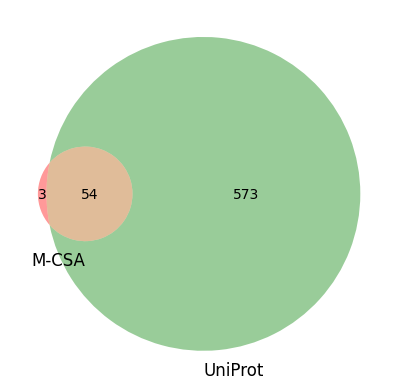

In [47]:
import matplotlib_venn

matplotlib_venn.venn2([set(df_mcsa_in_asd_grouped['pdb_uniprot_id']),
                       set(df_uniprot_site_annotations['uniprot_id'])],
                      ['M-CSA', 'UniProt']
                     )

In [48]:
df_uniprot_mcsa = df_uniprot_active_sites.merge(df_mcsa_in_asd_grouped, how='left', left_on='UniProt ID', right_on='pdb_uniprot_id')

active_site_residues = []

for ind, record in df_uniprot_mcsa.iterrows():
    if isinstance(record['catalytic_site_resids'], list):
        catalytic_site_resids = record['catalytic_site_resids']
    else:
        catalytic_site_resids = set()
    active_site_residues.append(sorted(set(record['Active Site Residues']) | catalytic_site_resids))

df_uniprot_mcsa['Active Site Residues'] = active_site_residues
df_uniprot_mcsa = df_uniprot_mcsa[['UniProt ID', 'Sequence', 'Active Site Residues']]
df_uniprot_mcsa

,UniProt ID,Sequence,Active Site Residues
0,D0PY27,SMSYTWTGALITPCAAEESKLPINALSNSLLRHHNMVYATTSRSAG...,[]
1,O27819,MKGIVLAGGSGTRLYPITRAVSKQLLPIYDKPMIYYPLSVLMLAGI...,"[8, 23, 80, 85, 108, 113, 114, 115, 116, 117, ..."
2,O33839,MKLSDLISRWIDVEPSKNAQIILRDRYFMKDLDGNYLETKWEDVAR...,"[26, 91, 127, 133, 141, 143, 158, 161, 171, 17..."
3,O43157,MPALGPALLQALWAGWVLTLQPLPPTAFTPNGTYLQHLARDPTSGT...,[]
4,O54438,MSLQGKVALVTGASRGIGQAIALELGRLGAVVIGTATSASGAEKIA...,"[12, 13, 14, 15, 37, 62, 63, 89, 141, 154, 155..."
...,...,...,...
837,Q13330,MAANMYRVGDYVYFENSSSNPYLIRRIEELNKTANGNVEAKVVCFY...,[]
838,Q2EG98,MLLQRRSWLWLYIRIGVILGDILGRKPSIREQHGGNSCYQLNRLFC...,[]
839,Q54324,MINKRSKVILHGNVKKTRRTGVYMISLDNSGNKDFSSNFSSERIRY...,"[53, 111, 141, 188, 191, 196, 215]"
840,Q55338,MKHIISAYNFSRDELEDIFALTDKYSKNLNDTRKILSGKTISIAFF...,"[51, 52, 80, 101, 129, 132, 162, 221, 260, 261]"


## Copy the allosteric site annotation to identical chains

In [49]:
df_asd_enriched.columns

Index(['Protein ASD ID', 'Gene', 'Organism', 'UniProt ID', 'PDB ID',
       'Protein Class', 'EC Number', 'Modulator ASD ID', 'Modulator Alias',
       'Modulator Chain', 'Modulator Class', 'Allosteric Activity',
       'Modulator Name', 'Modulator Residue ID', 'ASD Function', 'Position',
       'PubMed', 'Reference Title', 'Site Overlap',
       'ASD Allosteric Site Residues', 'Map PDB Chain to UniProt',
       'Oligomeric State', 'Stoichiometry', 'Experimental Method',
       'Resolution', 'Reviewed', 'Protein Name', '_uniprot_in_pdb'],
      dtype='object')

In [52]:
import collections
import itertools
import tqdm

allosteric_sites = []
for index, record in tqdm.tqdm(df_asd_enriched.iterrows(), total=df_asd_enriched.shape[0]):
    protein_allosteric_sites = []

    site_residues = []
    for residue in record['ASD Allosteric Site Residues']:
        residue = residue.upper()  # Change any lower case residue names or chains to upper case
        chain = residue[0]
        # Convert chains like '1', '2', ... to 'A', 'B', ...
        if chain.isnumeric():
            chain = chr(64 + int(chain))
            residue = chain + residue[1:]  # Update the chain in the residue
        site_residues.append(residue)

    # Create a dictionary with chains with each uniprot id
    uniprot_to_chains = collections.defaultdict(list)
    chains_to_uniprot = collections.defaultdict(list)
    for chain, uniprots, seq in record['Map PDB Chain to UniProt']:
        for uniprot_id in uniprots:
            uniprot_to_chains[uniprot_id].append(chain)
            chains_to_uniprot[chain].append(uniprot_id)

    for chain, residues in itertools.groupby(site_residues, key=lambda res: res[0]):
        residue_list = list(residues)
        for uniprot in chains_to_uniprot[chain]:
            for identical_chain in uniprot_to_chains[uniprot]:
                for res in residue_list:
                    protein_allosteric_sites.append(identical_chain + res[1:])
    allosteric_sites.append(protein_allosteric_sites)

df_asd_enriched['Allosteric Site Residues'] = allosteric_sites

100%|██████████| 3148/3148 [00:00<00:00, 45636.43it/s]


## Add active site annotation to identical chains

In [ ]:
import numpy as np

uniprot_to_active_sites_map = df_uniprot_active_sites[['UniProt ID', 'Active Site Residues']]
uniprot_to_active_sites_map.set_index('UniProt ID', drop=True, inplace=True)
uniprot_to_active_sites_map = uniprot_to_active_sites_map.to_dict()['Active Site Residues']

active_sites = []
for index, record in tqdm.tqdm(df_asd_enriched.iterrows(), total=df_asd_enriched.shape[0]):
    protein_active_sites = []
    for chain in record['Map PDB Chain to UniProt']:
        for uniprot_id in chain[1]:
            active_site = uniprot_to_active_sites_map[uniprot_id]
            if active_site is not np.nan:
                for residue in active_site:
                    protein_active_sites.append(f'{chain[0]}-{residue}')
    active_sites.append(protein_active_sites)

df_asd_enriched['Active Site Residues'] = active_sites

TypeError: 'module' object is not callable. Did you mean: 'tqdm.tqdm(...)'?

## Add Active Site Residues from UniProt to ASD

Filter the dataframe with at least one allosteric site reidue and one active or binding site residue

In [ ]:
# Drop the rows with no allosteric and active site residues
df_asd_with_active_site = df_asd_enriched[(df_asd_enriched['ASD Allosteric Site Residues'].apply(len) > 0) & (df_asd_enriched['Active Site Residues'].apply(len) > 0)]

print('Number of Rows:             ', df_asd_with_active_site.shape[0])
print('Number of Unique PDB IDs:   ', df_asd_with_active_site['PDB ID'].nunique())
print('Number of Unique UniProt AC:', df_asd_with_active_site['UniProt ID'].nunique())

Number of Rows:              2277
Number of Unique PDB IDs:    2165
Number of Unique UniProt AC: 446


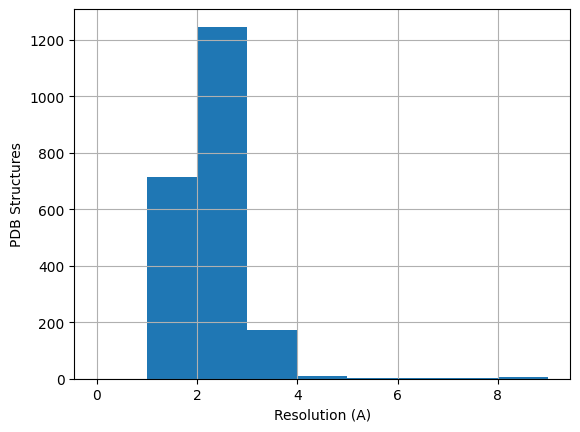

In [ ]:
hist = df_asd_with_active_site[['PDB ID', 'Resolution']].drop_duplicates().hist(column='Resolution', bins=range(0, 10))
for ax in hist.flatten():
    ax.set_title(None)
    ax.set_xlabel('Resolution (A)')
    ax.set_ylabel('PDB Structures')

## Select structures with resolution better than 4 Å

In [ ]:
resolution_cutoff = 4  # Select structures with a resolution better than 4 Angstroms
df_high_res = df_asd_with_active_site[df_asd_with_active_site['Resolution'] < resolution_cutoff].copy()

print('Number of Rows:             ', df_high_res.shape[0])
print('Number of Unique PDB IDs:   ', df_high_res['PDB ID'].nunique())
print('Number of Unique UniProt AC:', df_high_res['UniProt ID'].nunique())

df_high_res.to_csv('ASD_High_Resolution.csv', index=False)

Number of Rows:              2244
Number of Unique PDB IDs:    2133
Number of Unique UniProt AC: 436


## Download PDB files

The large structures with PDB IDs 4V9C, 3BCR, 8DD3, 7AIA, 6VVH, 7APH, 7OFU are not available in .pdb format. However, these are available in PDBx/mmCIF format

In [ ]:
import urllib

def download_structures(pdb_ids: list[str], download_dir: os.path = './') -> None:

    if not os.path.exists(download_dir):
        os.makedirs(download_dir)

    for pdb_id in tqdm(pdb_ids):
        pdb_id = pdb_id.lower()
        cif_file = os.path.join(download_dir, f'{pdb_id}.cif')
        if not os.path.exists(cif_file):
            try:
                urllib.request.urlretrieve(f'https://files.rcsb.org/download/{pdb_id}-assembly1.cif', cif_file)
            except urllib.error.HTTPError:
                print('Could not download', pdb_id.upper())

In [ ]:
download_structures(
    pdb_ids=df_high_res['PDB ID'].unique(),
    download_dir='pdb_structures/'
)

100%|█████████████████████████████████████████████████████████| 2133/2133 [00:00<00:00, 71685.73it/s]
